# Análisis exploratorio - ZonaProp

### Cargamos las librerias a utilizar.

In [1]:
%matplotlib inline
import pandas as pd # Trabajo de Dataframes
import seaborn as sns # Trabajo con plots estadisticos
import numpy as np # Trabajo con matrices
import matplotlib.pyplot as plt # Plots mas simples


#### Definimos algunas funciones que nos van a resultar útiles más adelante

In [2]:
def memory(df):
    memory = (df.memory_usage()/(1024*1024)).sum().round(2)
    print (memory,'MB')

#### Levantamos el Dataset

In [3]:
# Ojo la carpeta donde se guarda.
df = pd.read_csv('data/train.csv', index_col=['id'], parse_dates=['fecha'], error_bad_lines=False)

In [4]:
#Una manera prolija de ver rapidamente las columnas y un ejemplo de los datos en ellas.
df.head().transpose()

id,254099,53461,247984,209067,185997
titulo,depto. tipo a-402,condominio horizontal en venta,casa en venta urbi 3 recamaras tonala,casa sola en toluca zinacantepec con credito i...,paseos del sol
descripcion,"depto. interior de 80.15m2, consta de sala com...","<p>entre sonora y guerrero, atr&aacute;s del h...",descripcion \nla mejor ubicacion residencial e...,casa en privada con caseta de vigilancia casas...,bonito departamento en excelentes condiciones ...
tipodepropiedad,Apartamento,Casa en condominio,Casa,Casa,Apartamento
direccion,Avenida Division del Norte 2005,AV. MEXICO,Urbi Tonala,IGNACIO MANUEL ALTAMIRANO 128,PASEOS DEL SOL
ciudad,Benito Juárez,La Magdalena Contreras,Tonalá,Zinacantepec,Zapopan
provincia,Distrito Federal,Distrito Federal,Jalisco,Edo. de México,Jalisco
antiguedad,NaN,10,5,1,10
habitaciones,2,3,3,2,2
garages,1,2,2,1,1
banos,2,2,2,1,1


In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

### Compruebo la cantidad de NaN/Nulls que hay en cada columna del dataset

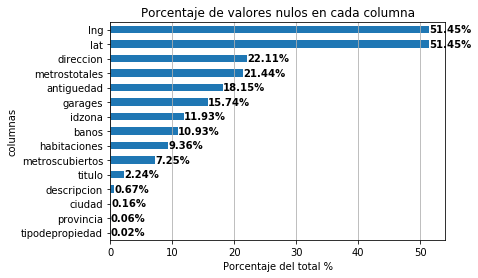

In [6]:
# Hay que ponerlo un poco más bonito pero me parece que ya cumple su función.
nulls = pd.DataFrame((df.isnull().sum().sort_values()/len(df)*100).round(2),columns=['porcentaje de NaN'])
nulls.drop(nulls.loc[nulls.loc[:,'porcentaje de NaN']<=0].index, inplace=True)
ax = nulls['porcentaje de NaN'].plot.barh()
ax.set_title('Porcentaje de valores nulos en cada columna')
ax.set_xlabel('Porcentaje del total %')
ax.set_ylabel('columnas')
ax.grid(axis='x')

for y, x in enumerate(nulls['porcentaje de NaN']):
    ax.text(x, y, s=str(x)+'%', color='black', fontweight='bold',va='center')


#### Del gráfico anterior, vemos que hay varias columnas con un porcentaje muy bajo de NaN. Los eliminamos porque son irrelevantes

In [7]:
df.dropna(subset=['tipodepropiedad','provincia','ciudad'],inplace=True)


## Optimización del DataFrame

#### Vemos cuanta memoria ocupa nuestro dataframe antes de la optimización

In [8]:
memory(df)

42.04 MB


#### Revisamos los dtypes y casteamos los que no sean adecuados

In [9]:
df.dtypes

titulo                                object
descripcion                           object
tipodepropiedad                       object
direccion                             object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
idzona                               float64
lat                                  float64
lng                                  float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio                               float64
dtype: obj

In [10]:
df.get_dtype_counts()

float64           15
datetime64[ns]     1
object             6
dtype: int64

#### Sospechamos que hay varias columnas que tienen dtype:float64 pero en realudad son booleanos. Comprombamos viendo si tienen solo dos valores únicos: 0 y 1.

In [11]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())
print("Valores únicos gym: ", df.gimnasio.unique())

Valores únicos piscina:  [0. 1.]
Valores únicos usos multiples:  [0. 1.]
Valores únicos escuelas cercanas:  [0. 1.]
Valores únicos centros comerciales cercanos:  [0. 1.]
Valores únicos gym:  [0. 1.]


#### Sospechamos que hay varias columnas que tienen dtype:float64 pero los valores que pueden tomar son del tipo entero. Comprobamos viendo los todos los posibles valores que toma cada columna

In [12]:
print("Valores únicos baños: ", df.banos.unique())
print("Valores únicos habitaciones: ", df.habitaciones.unique())
print("Valores únicos garages: ", df.garages.unique())


Valores únicos baños:  [ 2.  1.  3. nan  4.]
Valores únicos habitaciones:  [ 2.  3.  4. nan  5.  1.  9.  7. 10.  6.  8.]
Valores únicos garages:  [ 1.  2. nan  0.  3.]


#### Casteamos usando el método astype

In [13]:
# Como castear campos bool a int 16
df = df.astype({
    "piscina": 'int16', "usosmultiples": 'int16', "escuelascercanas": 'int16',
    "centroscomercialescercanos": 'int16', "gimnasio":'int16'})
# Baños, habitaciones y garages como ya comprobamos también hay que castearlos a int16 pero no se puede mientras hayan NaN.

In [14]:
memory(df) # Hemos disminuido en aproximadamente un 20% el tamaño

35.19 MB


In [15]:
#Veamos que todo sigue igual
df.head().transpose()

id,254099,53461,247984,209067,185997
titulo,depto. tipo a-402,condominio horizontal en venta,casa en venta urbi 3 recamaras tonala,casa sola en toluca zinacantepec con credito i...,paseos del sol
descripcion,"depto. interior de 80.15m2, consta de sala com...","<p>entre sonora y guerrero, atr&aacute;s del h...",descripcion \nla mejor ubicacion residencial e...,casa en privada con caseta de vigilancia casas...,bonito departamento en excelentes condiciones ...
tipodepropiedad,Apartamento,Casa en condominio,Casa,Casa,Apartamento
direccion,Avenida Division del Norte 2005,AV. MEXICO,Urbi Tonala,IGNACIO MANUEL ALTAMIRANO 128,PASEOS DEL SOL
ciudad,Benito Juárez,La Magdalena Contreras,Tonalá,Zinacantepec,Zapopan
provincia,Distrito Federal,Distrito Federal,Jalisco,Edo. de México,Jalisco
antiguedad,NaN,10.00,5.00,1.00,10.00
habitaciones,2.00,3.00,3.00,2.00,2.00
garages,1.00,2.00,2.00,1.00,1.00
banos,2.00,2.00,2.00,1.00,1.00


In [16]:
# here are all the attributes of both a pandas Series and a pandas DF
s_attr_methods = set(dir(pd.Series))
df_attr_methods = set(dir(pd.DataFrame))
len(s_attr_methods & df_attr_methods) #they share 400 methods

400

In [17]:
ciudad=df.ciudad
ciudad.value_counts().head()

Querétaro          12646
Benito Juárez      11014
Zapopan            10360
San Luis Potosí     7905
Mérida              7161
Name: ciudad, dtype: int64

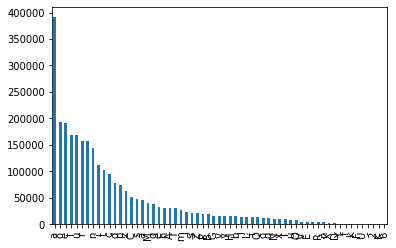

In [18]:
pd.Series(list(df.ciudad.str.cat())).value_counts().plot(kind="bar")

In [19]:
# Bring only columns with a certain type
df.select_dtypes('number')

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,
254099,nan,2.00,1.00,2.00,80.00,80.00,23533.00,nan,nan,0,0,0,0,0,2273000.00
53461,10.00,3.00,2.00,2.00,268.00,180.00,24514.00,19.31,-99.23,0,0,0,1,1,3600000.00
247984,5.00,3.00,2.00,2.00,144.00,166.00,48551.00,nan,nan,0,0,0,0,0,1200000.00
209067,1.00,2.00,1.00,1.00,63.00,67.00,53666.00,19.30,-99.69,0,0,0,1,1,650000.00
185997,10.00,2.00,1.00,1.00,95.00,95.00,47835.00,nan,nan,0,0,0,0,0,1150000.00
126147,5.00,2.00,1.00,1.00,75.00,90.00,23650.00,19.30,-99.15,0,0,0,0,1,1100000.00
139233,nan,3.00,1.00,2.00,140.00,160.00,73510.00,17.14,-96.80,0,0,0,0,0,1150000.00
5013,2.00,4.00,2.00,3.00,293.00,293.00,130510.00,20.67,-87.04,0,0,0,0,0,4200000.00
44962,1.00,2.00,1.00,1.00,58.00,nan,9010.00,nan,nan,0,0,0,1,1,310000.00


In [20]:
# DF tiene un indice (matriz), Serie tiene un indice (vector), la lista no.

counts_ciudad = df.ciudad.value_counts().tolist()
print(counts_ciudad)

[12646, 11014, 10360, 7905, 7161, 6946, 6633, 6614, 6554, 5795, 5783, 5721, 5716, 5293, 4636, 4006, 3805, 3779, 3775, 3757, 3587, 3408, 3254, 3141, 3093, 3020, 2863, 2590, 2454, 2159, 2048, 2026, 2018, 1996, 1972, 1905, 1887, 1865, 1845, 1470, 1457, 1452, 1429, 1386, 1370, 1360, 1340, 1294, 1292, 1285, 1249, 1245, 1207, 1066, 1055, 1046, 1029, 1029, 1000, 952, 931, 871, 861, 857, 832, 800, 793, 773, 759, 747, 728, 725, 665, 651, 627, 620, 617, 578, 574, 565, 553, 548, 523, 521, 520, 513, 485, 460, 459, 449, 444, 420, 418, 384, 378, 369, 351, 340, 329, 307, 293, 289, 287, 285, 279, 278, 267, 267, 264, 262, 246, 242, 240, 236, 233, 231, 229, 221, 211, 208, 195, 190, 177, 161, 154, 150, 147, 146, 146, 144, 133, 130, 130, 129, 126, 126, 124, 121, 120, 116, 111, 111, 110, 106, 102, 101, 91, 86, 85, 83, 83, 78, 77, 75, 75, 74, 74, 73, 70, 69, 68, 68, 67, 67, 65, 65, 61, 60, 56, 56, 56, 55, 54, 54, 54, 50, 50, 49, 48, 48, 47, 47, 47, 46, 45, 44, 43, 40, 40, 39, 39, 39, 38, 38, 36, 36, 35, 35,

In [21]:
#REVISAR
df.ciudad.value_counts().head()

Querétaro          12646
Benito Juárez      11014
Zapopan            10360
San Luis Potosí     7905
Mérida              7161
Name: ciudad, dtype: int64

In [22]:
df.isnull().any()

titulo                         True
descripcion                    True
tipodepropiedad               False
direccion                      True
ciudad                        False
provincia                     False
antiguedad                     True
habitaciones                   True
garages                        True
banos                          True
metroscubiertos                True
metrostotales                  True
idzona                         True
lat                            True
lng                            True
fecha                         False
gimnasio                      False
usosmultiples                 False
piscina                       False
escuelascercanas              False
centroscomercialescercanos    False
precio                        False
dtype: bool

In [23]:
df.isnull().sum()

titulo                          5382
descripcion                     1575
tipodepropiedad                    0
direccion                      52815
ciudad                             0
provincia                          0
antiguedad                     43328
habitaciones                   22415
garages                        37609
banos                          26090
metroscubiertos                17341
metrostotales                  51361
idzona                         28225
lat                           123259
lng                           123259
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

In [24]:
df.isnull().mean().sort_values()

precio                       0.00
tipodepropiedad              0.00
escuelascercanas             0.00
ciudad                       0.00
provincia                    0.00
piscina                      0.00
usosmultiples                0.00
gimnasio                     0.00
fecha                        0.00
centroscomercialescercanos   0.00
descripcion                  0.01
titulo                       0.02
metroscubiertos              0.07
habitaciones                 0.09
banos                        0.11
idzona                       0.12
garages                      0.16
antiguedad                   0.18
metrostotales                0.21
direccion                    0.22
lat                          0.51
lng                          0.51
dtype: float64

In [25]:
df.describe(include='all')

,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
count,234218,238025,239600,186785,239600,239600,196272.00,217185.00,201991.00,213510.00,222259.00,188239.00,211375.00,116341.00,116341.00,239600,239600.00,239600.00,239600.00,239600.00,239600.00,239600.00
unique,186018,231839,24,140148,875,32,nan,nan,nan,nan,nan,nan,nan,nan,nan,1830,nan,nan,nan,nan,nan,nan
top,casa en venta,empresa dedicada a los ante notario y regist...,Casa,-,Querétaro,Distrito Federal,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-03 00:00:00,nan,nan,nan,nan,nan,nan
freq,459,119,141479,660,12646,58770,nan,nan,nan,nan,nan,nan,nan,nan,nan,1416,nan,nan,nan,nan,nan,nan
first,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,2012-01-01 00:00:00,nan,nan,nan,nan,nan,nan
last,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-31 00:00:00,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.12,2.90,1.55,2.13,173.98,176.73,2423511.80,20.70,-99.51,NaN,0.06,0.06,0.09,0.44,0.40,2530628.83
std,NaN,NaN,NaN,NaN,NaN,NaN,9.55,0.90,0.85,0.91,98.15,94.42,10568033.52,3.14,9.72,NaN,0.24,0.23,0.28,0.50,0.49,2152399.57
min,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,1.00,15.00,15.00,22.00,-100.89,-125.86,NaN,0.00,0.00,0.00,0.00,0.00,310000.00
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2.00,1.00,1.00,90.00,102.00,24889.50,19.36,-100.98,NaN,0.00,0.00,0.00,0.00,0.00,952000.00


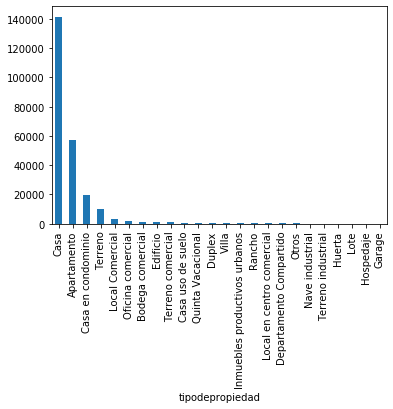

In [26]:
df.groupby(by=['tipodepropiedad']).size().sort_values(ascending=False).plot(kind="bar")

In [27]:
df.index.values.sum()

35933038695

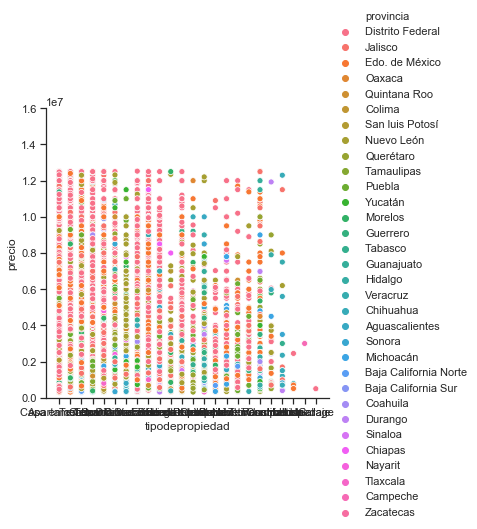

In [28]:
corr_tipoprop_precio = df[['precio', 'tipodepropiedad', 'provincia']]
sns.set(style="darkgrid")
sns.set(style="ticks", color_codes=True)
g = sns.relplot(x='tipodepropiedad', y='precio', data=corr_tipoprop_precio, hue='provincia')
g.set(ylim=(0, 16000000))